In [68]:
import orbit 
from orbit.models import DLT #one of the Orbit models  
from orbit.diagnostics.plot import plot_predicted_data, plot_predicted_components #for plotting predictions

#for data wrangling
import pandas as pd
import pandahouse as ph
import numpy as np
import os

#for plotting
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az #this is useful for MCMC visualization

In [69]:
from orbit.diagnostics.plot import (
    plot_predicted_data,
    plot_predicted_components
)

In [70]:
# for model quality evaluation (backtesting)
from orbit.diagnostics.backtest import BackTester #main class for backtesting
from orbit.utils.params_tuning import grid_search_orbit #for optimal parameter selection

In [71]:
connection = {'host': ' http://clickhouse.lab.karpov.courses:8123',
'database':'simulator_20241020',
'user':'student',
'password':'dpo_python_2020'
}

In [72]:
query = '''
SELECT 
    toStartOfHour(time) hour_time,
    countIf(action = 'like')/countIf(action = 'view') CTR
FROM 
    simulator.feed_actions_all
WHERE hour_time >= toDateTime('2021-11-19 00:00:00')
  AND hour_time <= toDateTime('2021-12-19 00:00:00')
GROUP BY hour_time
ORDER BY 
    hour_time
'''

In [73]:
activity = ph.read_clickhouse(query=query, connection=connection)
activity.head()

,hour_time,CTR
0,2021-11-19 00:00:00,0.220865
1,2021-11-19 01:00:00,0.216720
2,2021-11-19 02:00:00,0.213163
3,2021-11-19 03:00:00,0.211687
4,2021-11-19 04:00:00,0.216482


In [74]:
#seaborn settings
sns.set(rc={'figure.figsize':(16,6)}, style="whitegrid")

Text(0.5, 1.0, 'CTR over time')

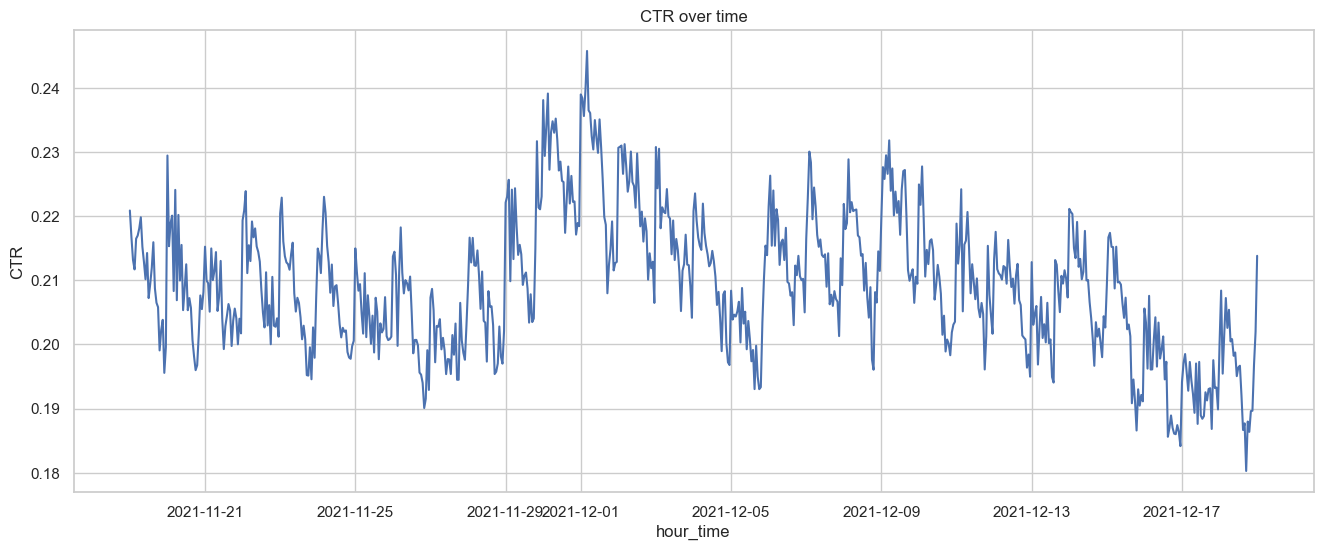

In [75]:
sns.lineplot(data=activity,x='hour_time',y='CTR')
plt.title('CTR over time')

In [76]:
dir(orbit)

['Path',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 'about',
 'constants',
 'diagnostics',
 'eda',
 'estimators',
 'exceptions',
 'f',
 'forecaster',
 'here',
 'models',
 'template',
 'utils']

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

df = activity.copy()
df["hour_time"] = pd.to_datetime(df["hour_time"])

df["date"] = df["hour_time"].dt.day
df["hour"] = df["hour_time"].dt.hour

In [78]:
heatmap_data = df.pivot_table(
    index="hour",
    columns="date",
    values="CTR",
    aggfunc="mean"
)

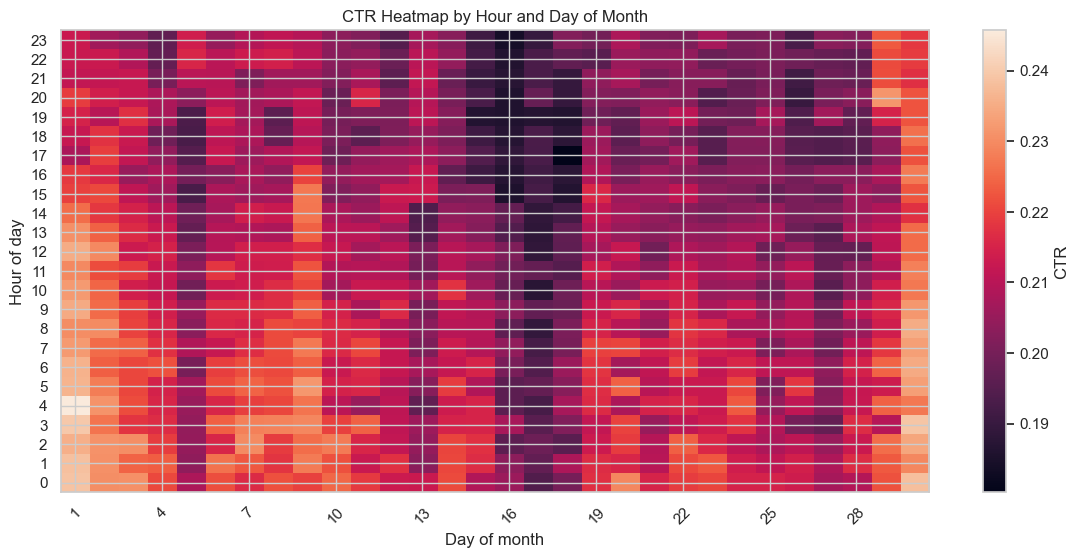

In [79]:
plt.figure(figsize=(14, 6))
plt.imshow(
    heatmap_data,
    aspect="auto",
    origin="lower"
)

plt.colorbar(label="CTR")
plt.xlabel("Day of month")
plt.ylabel("Hour of day")
plt.title("CTR Heatmap by Hour and Day of Month")

plt.xticks(
    ticks=range(0, len(heatmap_data.columns), max(1, len(heatmap_data.columns)//10)),
    labels=heatmap_data.columns[::max(1, len(heatmap_data.columns)//10)],
    rotation=45
)

plt.yticks(range(24))
plt.show()

In [80]:
heatmap_norm = (
    heatmap_data - heatmap_data.mean()
) / heatmap_data.std()

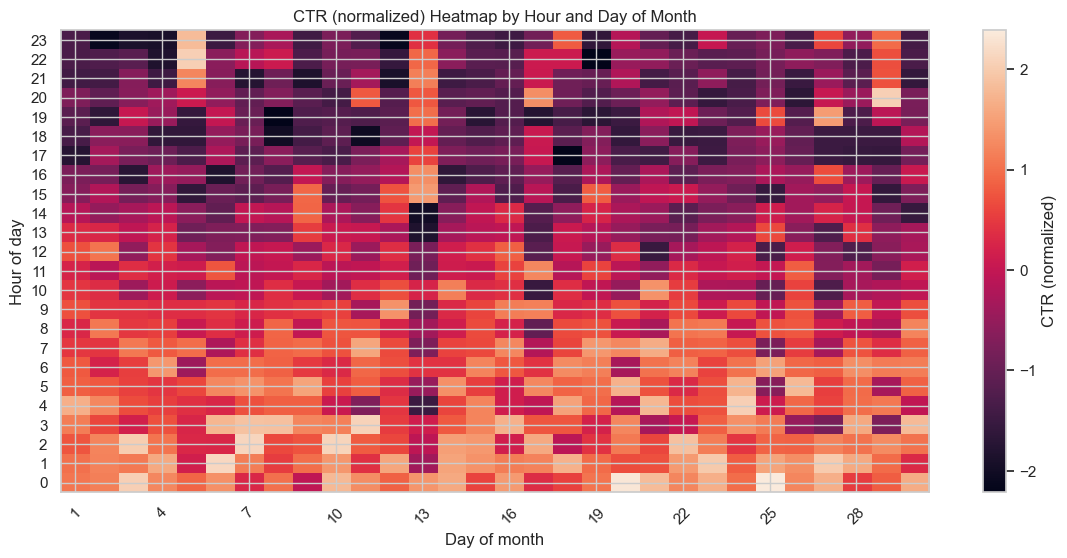

In [81]:
plt.figure(figsize=(14, 6))
plt.imshow(
    heatmap_norm,
    aspect="auto",
    origin="lower"
)

plt.colorbar(label="CTR (normalized)")
plt.xlabel("Day of month")
plt.ylabel("Hour of day")
plt.title("CTR (normalized) Heatmap by Hour and Day of Month")

plt.xticks(
    ticks=range(0, len(heatmap_norm.columns), max(1, len(heatmap_norm.columns)//10)),
    labels=heatmap_norm.columns[::max(1, len(heatmap_norm.columns)//10)],
    rotation=45
)

plt.yticks(range(24))
plt.show()

## Forecast
Orbit has three main models:

* **Local-Global Trend** - takes into account both general global changes and smaller local ones - but the developers themselves want to get rid of it
* **Damped Local Trend** - a hybrid of the previous model and classic exponential smoothing + trend decay coefficient
* **Kernel-based time-varying regression** - an experimental model with multiple seasonality and dynamic regression (may have bugs!)



In [82]:
# I use Damped Local Trend model. To begin with, I initialize the model with the basic parameters:
dlt = DLT(response_col="CTR", #column name with the metric
          date_col="hour_time", #column name with dates-time
          seasonality=24, #length of the seasonality period
          estimator="stan-map", #estimation algorithm
          n_bootstrap_draws=1000) #number of bootstrap samples for confidence interval

2026-01-02 18:41:09 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.


In [83]:
# Fit the model to the data
dlt.fit(activity)

In [84]:
# reating a data frame with a forecasting horizon
future_df = dlt.make_future_df(periods=24*7) #predict one week ahead (24 hours * 7 day)
future_df.head()

,hour_time
0,2021-12-19 01:00:00
1,2021-12-19 02:00:00
2,2021-12-19 03:00:00
3,2021-12-19 04:00:00
4,2021-12-19 05:00:00


In [85]:
predicted_df = dlt.predict(df=future_df)
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95
0,2021-12-19 01:00:00,0.204435,0.210797,0.217887
1,2021-12-19 02:00:00,0.202480,0.209511,0.217358
2,2021-12-19 03:00:00,0.201317,0.208784,0.217199
3,2021-12-19 04:00:00,0.200219,0.207294,0.216207
4,2021-12-19 05:00:00,0.199617,0.208107,0.217845


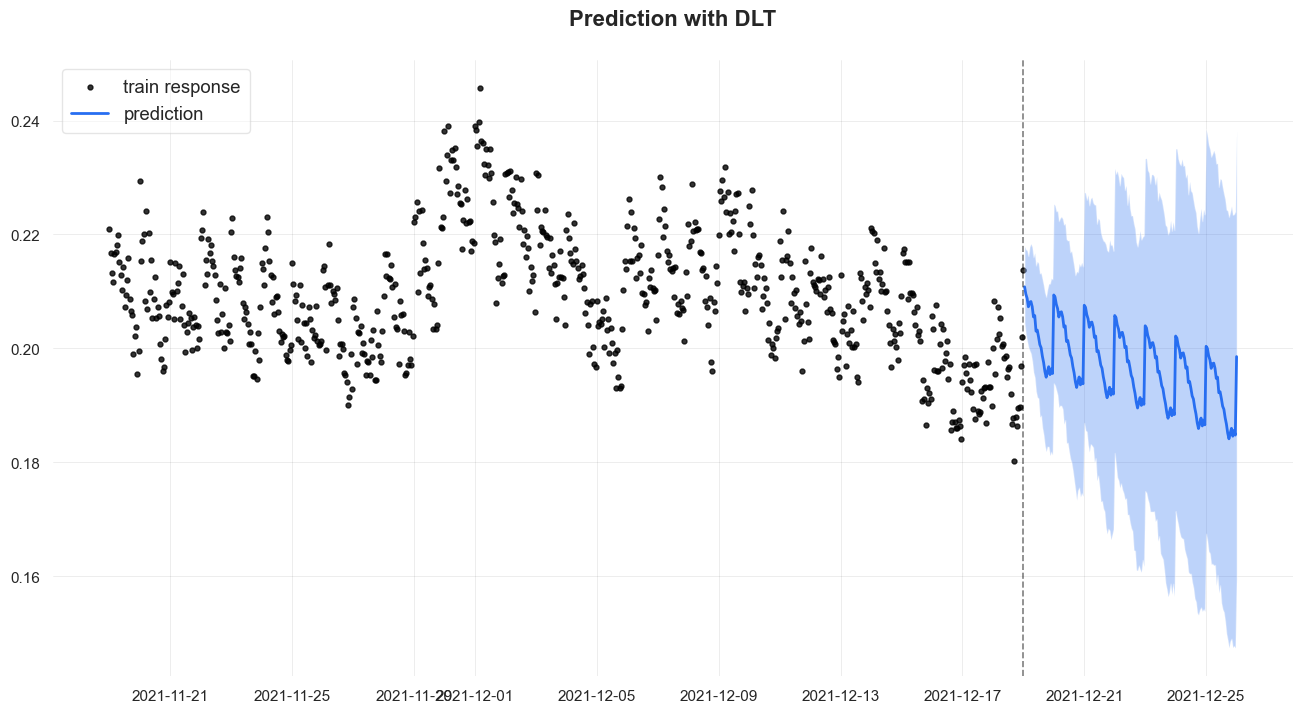

In [86]:
_ = plot_predicted_data(activity, predicted_df, "hour_time", 'CTR', title='Prediction with DLT')

In [87]:
predicted_df = dlt.predict(df=future_df, 
                           decompose=True) #to get components
predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2021-12-19 01:00:00,0.204227,0.210797,0.217785,0.196651,0.203221,0.210208,0.007577,0.007577,0.007577,0.0,0.0,0.0
1,2021-12-19 02:00:00,0.202339,0.209511,0.217142,0.195974,0.203147,0.210777,0.006364,0.006364,0.006364,0.0,0.0,0.0
2,2021-12-19 03:00:00,0.200687,0.208784,0.216876,0.194976,0.203072,0.211165,0.005712,0.005712,0.005712,0.0,0.0,0.0
3,2021-12-19 04:00:00,0.198264,0.207294,0.215467,0.193968,0.202998,0.211172,0.004295,0.004295,0.004295,0.0,0.0,0.0
4,2021-12-19 05:00:00,0.199348,0.208107,0.216663,0.194165,0.202924,0.211480,0.005183,0.005183,0.005183,0.0,0.0,0.0


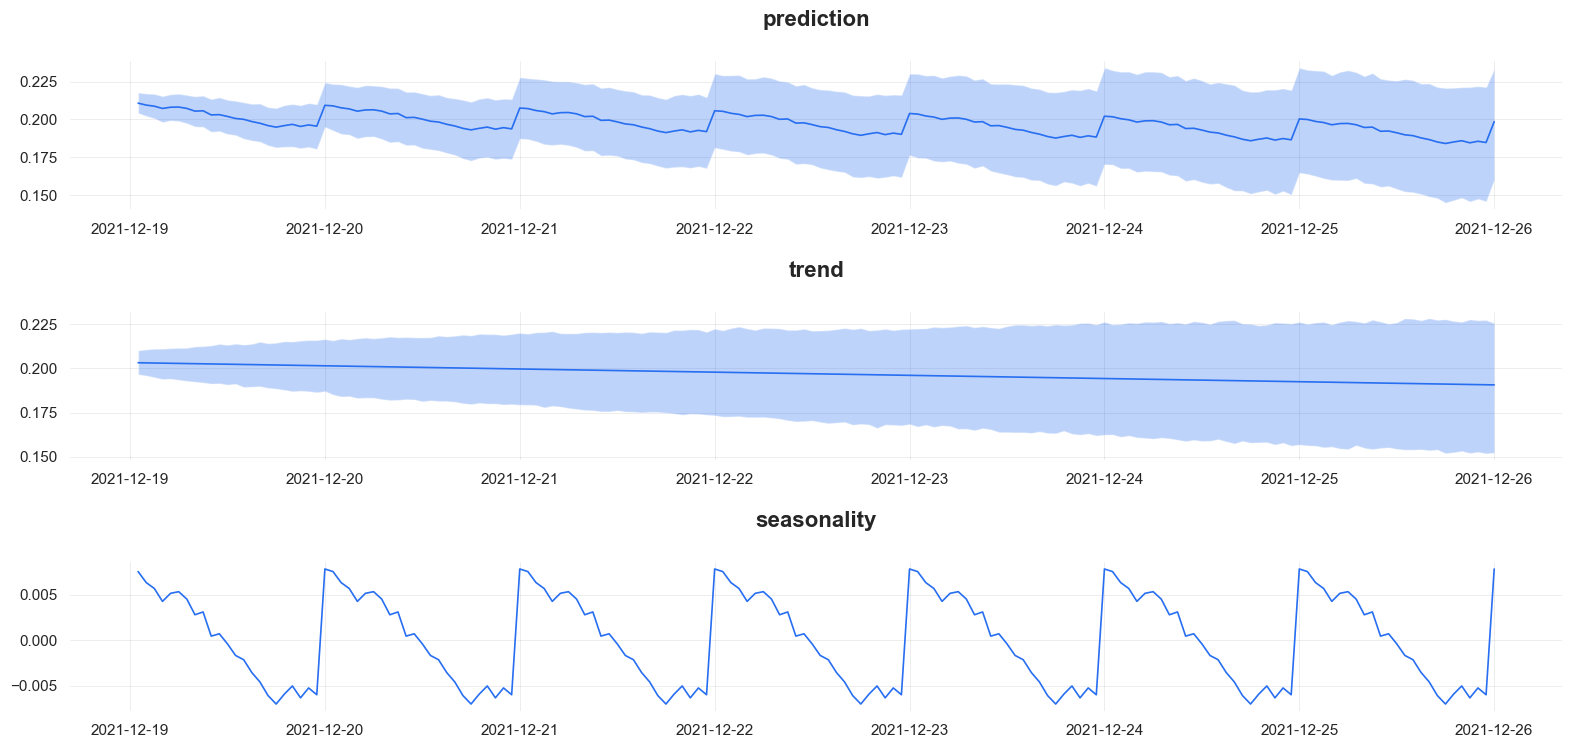

In [88]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

## New Forecast (MCMC)

The Markov Chain Monte Carlo (MCMC) method estimates confidence intervals for everything, including seasonality, and has much more theoretical guarantees of accuracy—but it is slower.

In [89]:
dlt_mcmc = DLT(seasonality=24, response_col="CTR", date_col="hour_time", 
               estimator='stan-mcmc', #new estimation algorithm - Метод Markov Chain Monte Carlo (MCMC) 
               num_warmup=2000, #warm-up time
               num_sample=1000) #sampling time

In [90]:
dlt_mcmc.fit(activity)

2026-01-02 18:41:12 - orbit - INFO - Sampling (CmdStanPy) with chains: 4, cores: 8, temperature: 1.000, warmups (per chain): 500 and samples(per chain): 250.
chain 1:   0%|          | 0/750 [00:00<?, ?it/s, (Warmup)]






chain 1:  27%|██▋       | 200/750 [00:08<00:22, 24.74it/s, (Warmup)]


chain 1:  40%|████      | 300/750 [00:10<00:13, 33.31it/s, (Warmup)]

chain 1:  53%|█████▎    | 400/750 [00:11<00:08, 40.97it/s, (Warmup)]

chain 1:  67%|██████▋   | 500/750 [00:13<00:05, 47.22it/s, (Sampling)]




chain 1:  80%|████████  | 600/750 [00:15<00:02, 50.03it/s, (Sampling)]


chain 1:  93%|█████████▎| 700/750 [00:17<00:00, 50.99it/s, (Sampling)]


chain 1: 100%|██████████| 750/750 [00:17<00:00, 52.66it/s, (Sampling)]






chain 2: 100%|██████████| 750/750 [00:23<00:00, 32.59it/s, (Sampling completed)]

chain 3: 100%|██████████| 750/750 [00:23<00:00, 32.59it/s, (Sampling completed)]


chain 4: 100%|██████████| 750/750 [00:23<00:00, 32.59it/s, (Sampling completed)]

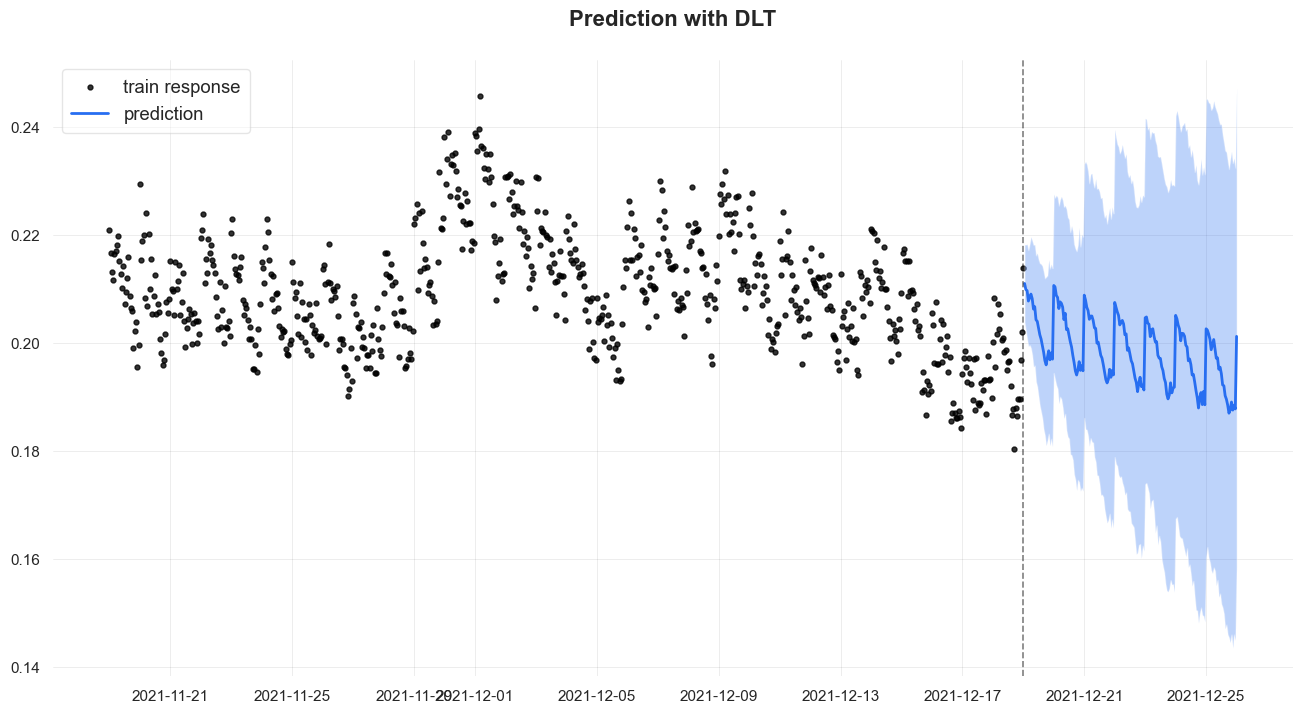

In [91]:
future_df = dlt_mcmc.make_future_df(periods=24*7)

predicted_df = dlt_mcmc.predict(df=future_df)

_ = plot_predicted_data(activity, predicted_df, "hour_time", 'CTR', title='Prediction with DLT')

In [92]:
predicted_df = dlt_mcmc.predict(df=future_df, decompose=True)

predicted_df.head()

,hour_time,prediction_5,prediction,prediction_95,trend_5,trend,trend_95,seasonality_5,seasonality,seasonality_95,regression_5,regression,regression_95
0,2021-12-19 01:00:00,0.203427,0.211062,0.217480,0.195677,0.203216,0.209718,0.006618,0.007770,0.008831,0.0,0.0,0.0
1,2021-12-19 02:00:00,0.201799,0.209670,0.217283,0.195157,0.203089,0.210749,0.005540,0.006581,0.007531,0.0,0.0,0.0
2,2021-12-19 03:00:00,0.200966,0.209430,0.217697,0.194967,0.203181,0.211711,0.004656,0.006005,0.007219,0.0,0.0,0.0
3,2021-12-19 04:00:00,0.198652,0.207449,0.216178,0.194778,0.203240,0.212121,0.003111,0.004157,0.005149,0.0,0.0,0.0
4,2021-12-19 05:00:00,0.199033,0.208335,0.218195,0.193955,0.203152,0.213100,0.004269,0.005215,0.006163,0.0,0.0,0.0


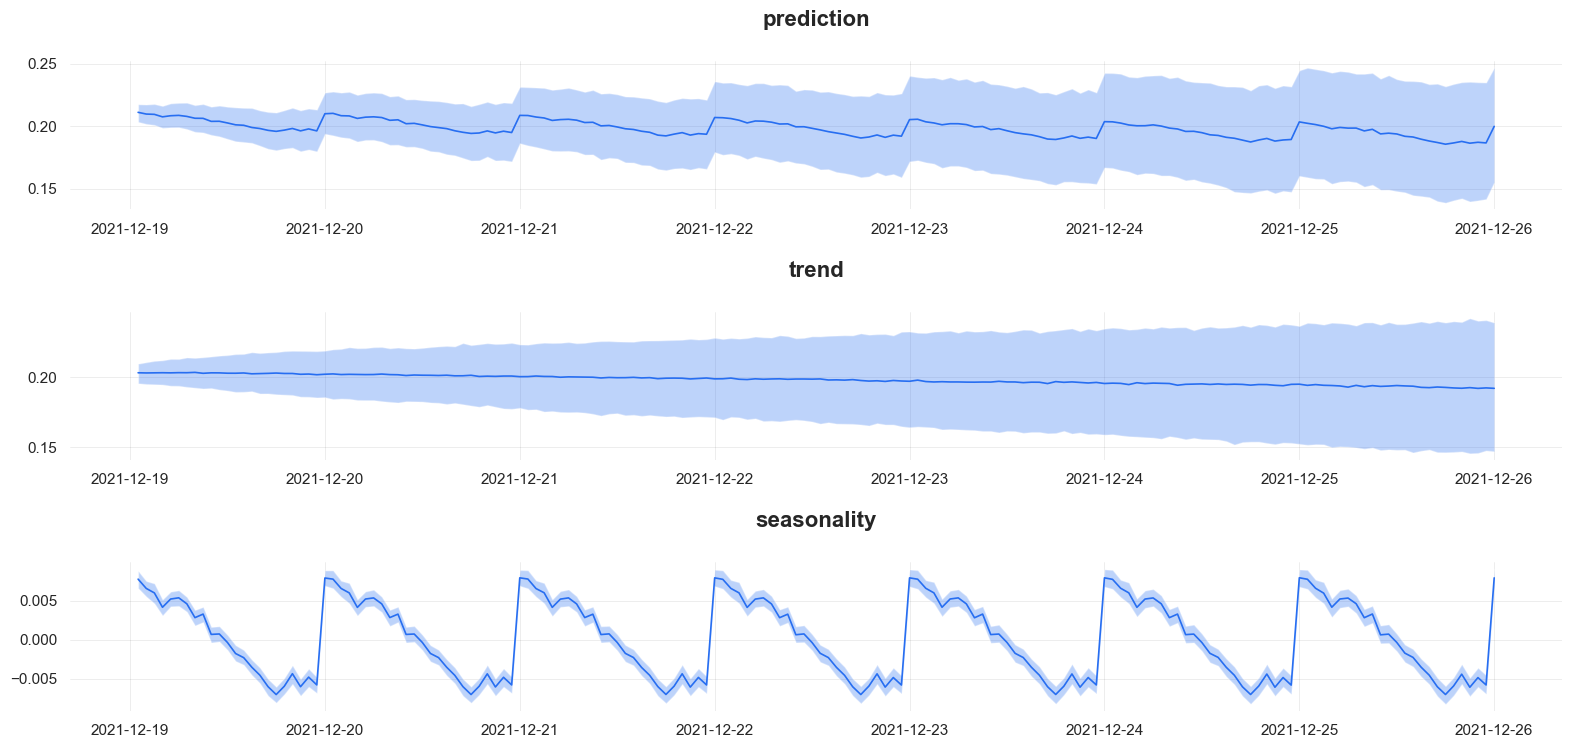

In [93]:
_ = plot_predicted_components(predicted_df, "hour_time", plot_components=['prediction', 'trend', 'seasonality'])

##  Model quality check
In Orbit, model quality testing is implemented through the concept of **backtesting** (**expanding** and **rolling window**.)

In [94]:
#expanding

bt_exp = BackTester(
    model=dlt, #model for backtesting
    df=activity, #dataframe for training
    min_train_len=24*7, #smallest piece of data to start training
    incremental_len=24, #how much the training data increases
    forecast_len=24, #forecasting horizon
    window_type='expanding' # window type
)

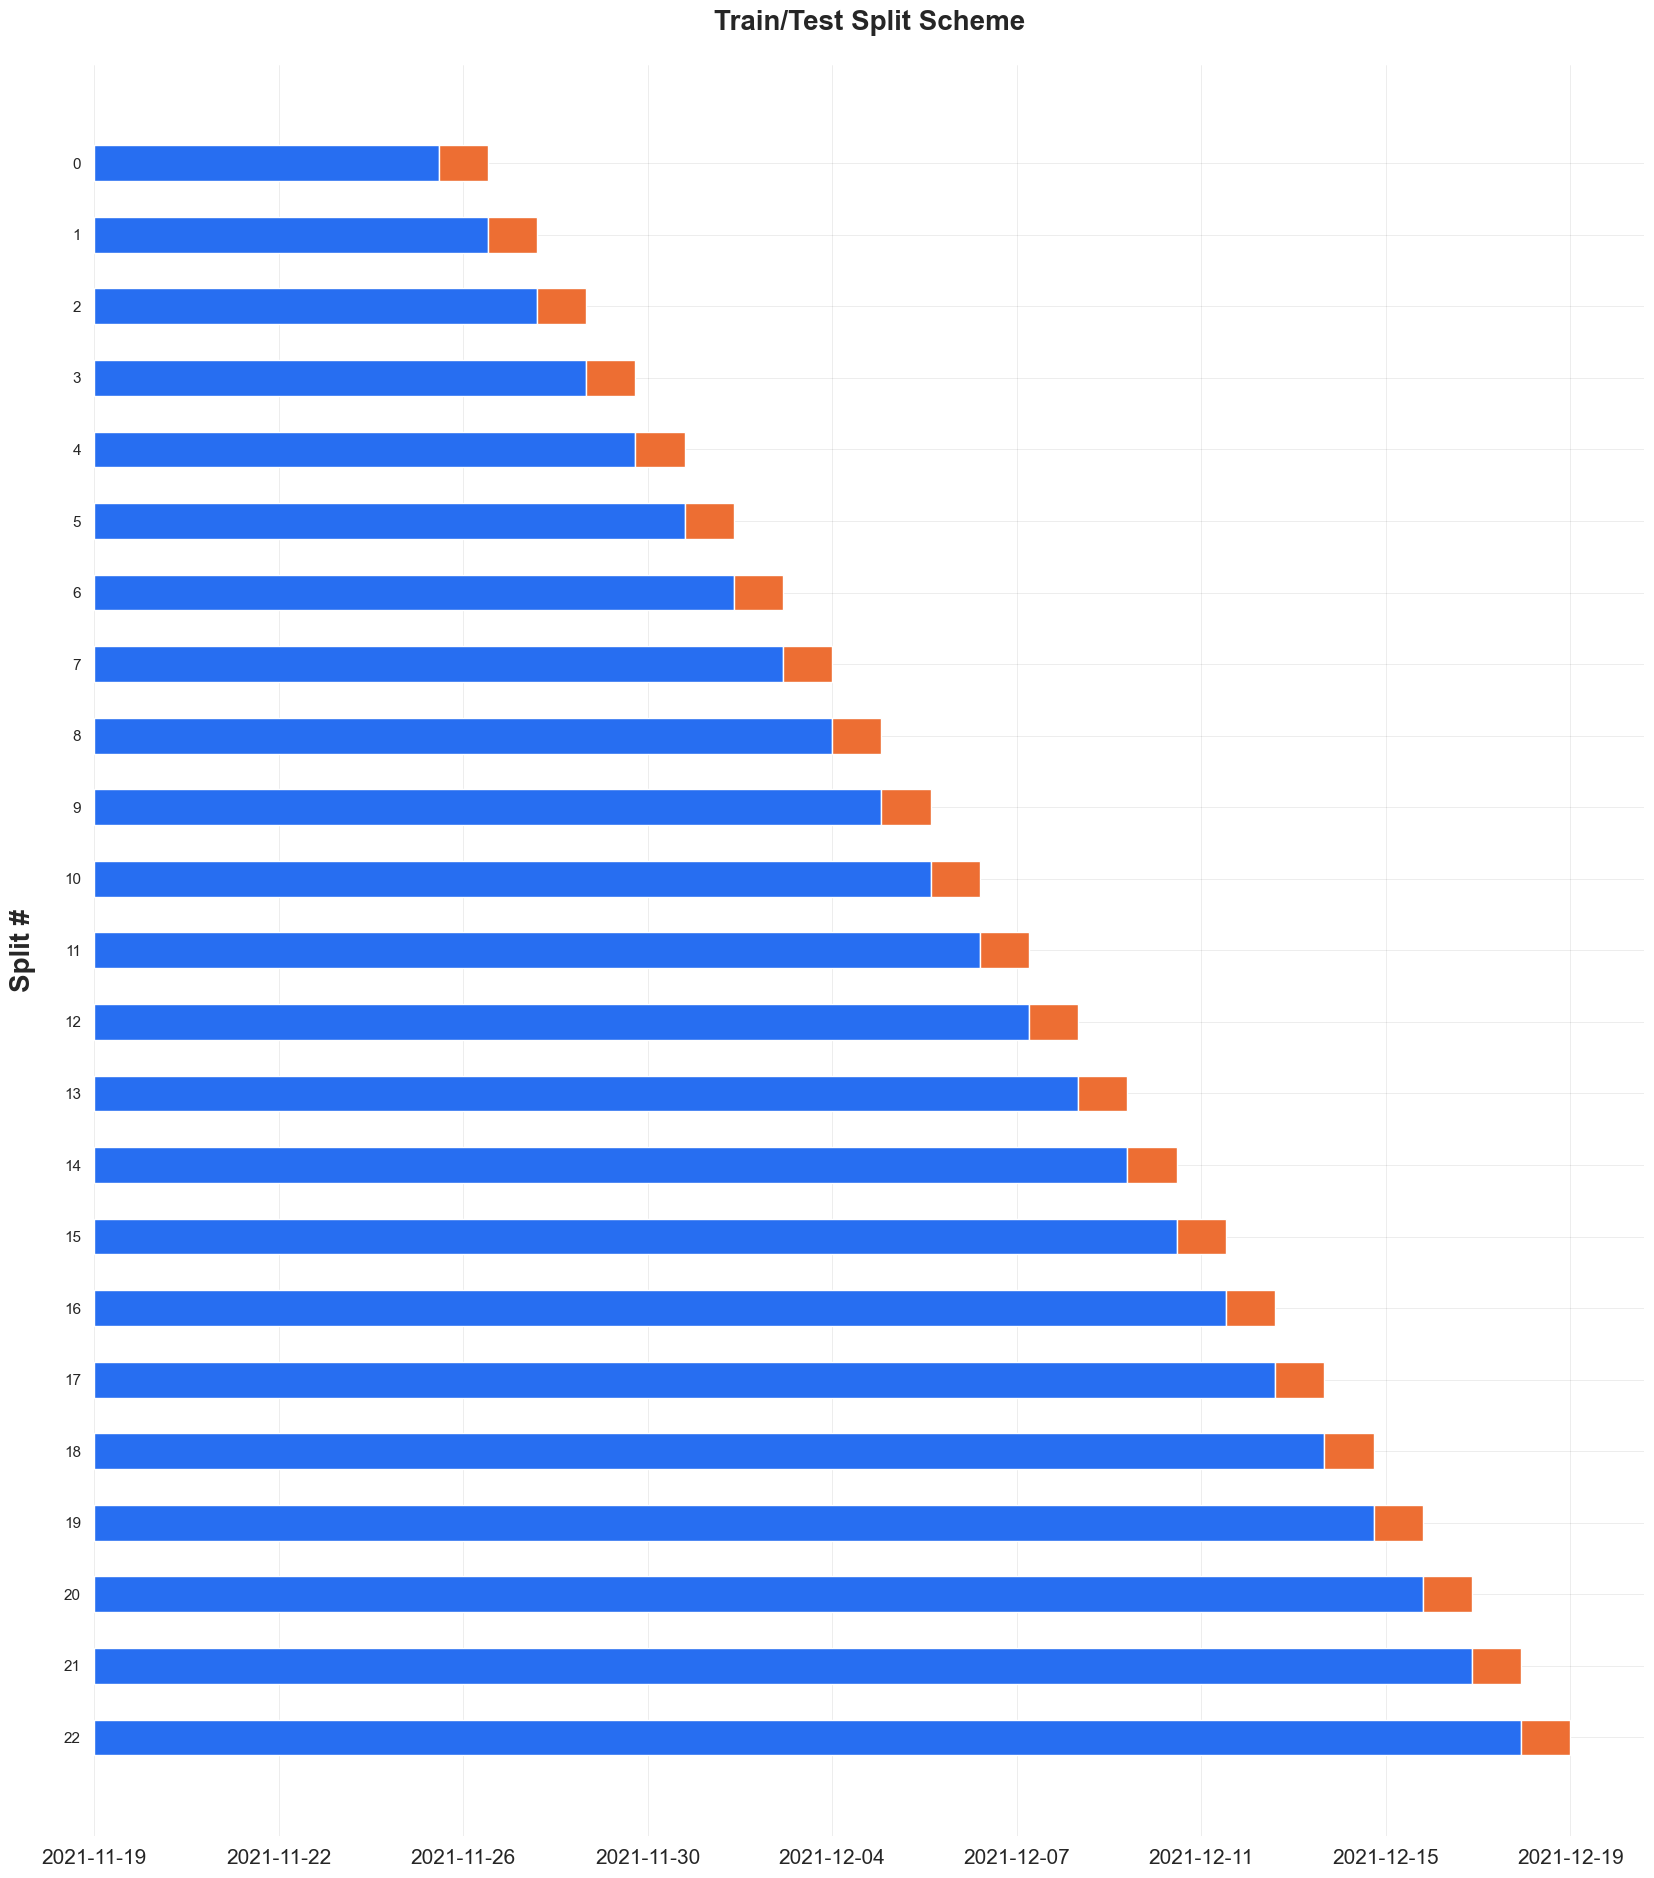

In [95]:
bt_exp.plot_scheme()

In [96]:
bt_exp.fit_predict() #train the model
bt_exp.score() #output metrics

,metric_name,metric_values,is_training_metric
0,smape,0.022803,False
1,wmape,0.022706,False
2,mape,0.022712,False
3,mse,0.000039,False
4,mae,0.004763,False
5,rmsse,1.072852,False



### Model Evaluation Summary

The model shows strong overall performance with low and stable errors.

- **MAPE / WMAPE / SMAPE ≈ 2.3%**  
  Predictions are, on average, within ~2–3% of the true CTR, which is very good for time-series CTR forecasting.

- **MAE = 0.0048**  
  Average absolute error is small in raw CTR units, indicating tight predictions with no large deviations.

- **MSE = 0.000039**  
  Low squared error suggests the absence of large outliers and stable model behavior.

- **RMSSE = 1.07**  
  Slightly worse than a naive baseline (≈7%), likely because the series is stable and the naive forecast is already strong. This is common for CTR data and not a major concern given the low percentage errors.

**Conclusion:**  
The model is accurate, stable, and suitable for production use. While it does not outperform a naive baseline on RMSSE, it provides strong relative accuracy and reliable forecasts overall.

<!--
### Model Evaluation Summary

The model shows strong overall performance with low and stable errors.

- **MAPE / WMAPE / SMAPE ≈ 2.3%**  
  Predictions are, on average, within ~2–3% of the true CTR, which is very good for time-series CTR forecasting.

- **MAE = 0.0048**  
  Average absolute error is small in raw CTR units, indicating tight predictions with no large deviations.

- **MSE = 0.000039**  
  Low squared error suggests the absence of large outliers and stable model behavior.

- **RMSSE = 1.07**  
  Slightly worse than a naive baseline (≈7%), likely because the series is stable and the naive forecast is already strong. This is common for CTR data and not a major concern given the low percentage errors.

**Conclusion:**  
The model is accurate, stable, and suitable for production use. While it does not outperform a naive baseline on RMSSE, it provides strong relative accuracy and reliable forecasts overall.
-->

In [97]:
best_params, tuned_df = grid_search_orbit(param_grid={"damped_factor": np.arange(0.1, 1.0, 0.1)}, #parameter grid
                                        model=dlt,
                                        df=activity,
                                        min_train_len=24*7,
                                        incremental_len=24,
                                        forecast_len=24,
                                        metrics=None, # smape default
                                        criteria="min", # minimize
                                        verbose=True) # print progress

  0%|          | 0/9 [00:00<?, ?it/s]2026-01-02 18:41:46 - orbit - INFO - tuning hyper-params {'damped_factor': np.float64(0.1)}
2026-01-02 18:41:46 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2026-01-02 18:41:55 - orbit - INFO - tuning metric:0.022766
 11%|█         | 1/9 [00:09<01:14,  9.36s/it]2026-01-02 18:41:55 - orbit - INFO - tuning hyper-params {'damped_factor': np.float64(0.2)}
2026-01-02 18:41:55 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2026-01-02 18:42:05 - orbit - INFO - tuning metric:0.022767
 22%|██▏       | 2/9 [00:18<01:05,  9.33s/it]2026-01-02 18:42:05 - orbit - INFO - tuning hyper-params {'damped_factor': np.float64(0.30000000000000004)}
2026-01-02 18:42:05 - orbit - INFO - Optimizing (CmdStanPy) with algorithm: LBFGS.
2026-01-02 18:42:14 - orbit - INFO - tuning metric:0.022657
 33%|███▎      | 3/9 [00:27<00:55,  9.23s/it]2026-01-02 18:42:14 - orbit - INFO - tuning hyper-params {'damped_factor': np.float64(0.4)}
2026-01-02 18:4

In [98]:
best_params

[{'damped_factor': 0.5}]

In [99]:
tuned_df

,damped_factor,metrics
0,0.1,0.022766
1,0.2,0.022767
2,0.3,0.022657
3,0.4,0.022689
4,0.5,0.022629
5,0.6,0.022665
6,0.7,0.022680
7,0.8,0.022723
8,0.9,0.022731


## Check MCMC

In [ ]:
params = dlt_mcmc.get_posterior_samples(permute=False)


In [101]:
params.keys()

dict_keys(['l', 'b', 'lev_sm', 'slp_sm', 'obs_sigma', 'nu', 'lt_sum', 's', 'sea_sm', 'gt_sum', 'gb', 'gl', 'loglk'])

In [102]:
params["obs_sigma"].shape

(4, 250)

array([[<Axes: title={'center': 'obs_sigma'}>,
        <Axes: title={'center': 'obs_sigma'}>]], dtype=object)

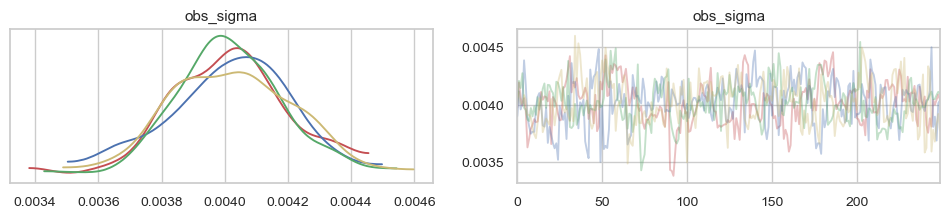

In [103]:
az.plot_trace(params, chain_prop={"color": ['r', 'b', 'g', 'y']}, var_names = "obs_sigma")